In [27]:
import h5py
import numpy as np
import os

root_dir = "./data"

with h5py.File(os.path.join(root_dir, "SK_DownsampledGANFocusAreaData.h5"), 'r') as f:
    y = f.get('X_train')
    y = np.array(y, dtype=np.float32)
    images = f.get('y_train')
    images = np.array(images, dtype=np.float32)

std1, std2 = np.std(y[:,0]), np.std(y[:,1])
y[:, 0] /= std1
y[:, 1] /= std2

In [28]:
from src.gan import Generator
from src.smaller_generator import SmallerGenerator
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator(2, 2).to(device)
G.load_state_dict(torch.load("./outputs/generator.pth", map_location=device))
G.eval()

SmallerG = SmallerGenerator(2, 2).to(device)
SmallerG.load_state_dict(torch.load("./smaller_outputs/smaller_generator.pth", map_location=device))
SmallerG.eval()



SmallerGenerator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [29]:
index = 100

FloatTensor = torch.cuda.FloatTensor if device!=torch.device("cpu") else torch.FloatTensor
downsampled_image = images[index]
label = y[index][:2]

label = FloatTensor(label)
label = torch.unsqueeze(label, dim=0)
#z_noise = FloatTensor(np.random.uniform(-1.0, 1.0, size=(1, 2)))
z_noise = FloatTensor([[0.0, 0.0]])

with torch.no_grad():
    image_DCGAN = (G(z_noise, label).cpu().numpy()[0][0]+1.0)/2.
    image_MLP = (SmallerG(z_noise, label).cpu().numpy()[0][0]+1.0)/2.


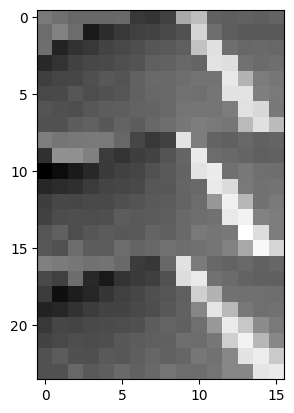

In [30]:
from filecmp import cmp
import matplotlib.pyplot as plt

plotted_image = np.concatenate([downsampled_image, image_DCGAN, image_MLP], axis=0)
plt.imshow(plotted_image, cmap="gray")

In [95]:
i = np.arange(10000)
np.random.shuffle(i)
b_size = 500
indexes = i[:b_size]
downsampled_images = images[indexes]
labels = y[indexes][:, :2]


In [101]:
from src.nnet import NNet
ys = FloatTensor(labels)
z_noise = FloatTensor(np.random.uniform(-0.8, 0.8, size=(b_size, 2)))

with torch.no_grad():
    x_generated = SmallerG(z_noise, ys).cpu().numpy()

nnet = NNet("./models/nnet/TinyTaxiNet.nnet")

ys_ds = []
ys_g = []
ys_gt = []
for idx, (ds_image, g_image) in enumerate(zip(downsampled_images, x_generated)):
    y_ds = nnet.evaluate_network(ds_image.flatten())
    y_g = nnet.evaluate_network(((g_image+1.)/2.).flatten())
    ys_ds.append(y_ds)
    ys_g.append(y_g)
    ys_gt.append(labels[idx]*[std1, std2])
print(len(ys_ds), len(ys_g), len(ys_gt))
    
#y_hat = nnet.evaluate_network(downsampled_images[250].flatten())
#print(y_hat/[std1, std2], labels[250])

500 500 500


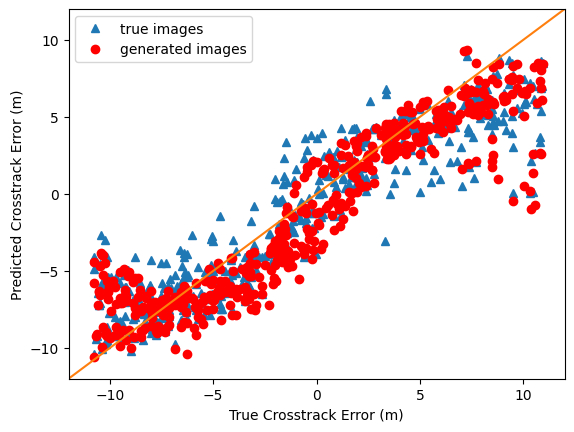

In [105]:
ys_gt = np.array(ys_gt)
ys_ds = np.array(ys_ds)
ys_g = np.array(ys_g)
plt.xlim([-12, 12])
plt.ylim([-12, 12])
plt.xlabel("True Crosstrack Error (m)")
plt.ylabel("Predicted Crosstrack Error (m)")
x1 = np.linspace(-12, 12, 1000)
plt.plot(ys_gt[:, 0], ys_ds[:, 0], '^')
plt.plot(ys_gt[:, 0], ys_g[:, 0], 'ro')
plt.legend(["true images", "generated images"])
plt.plot(x1, x1)

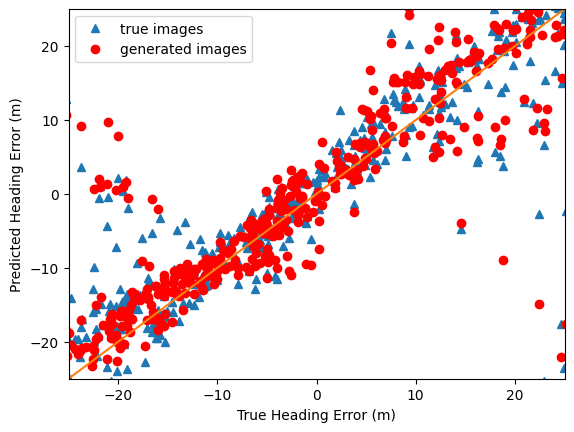

In [107]:
plt.xlim([-25, 25])
plt.ylim([-25, 25])
plt.xlabel("True Heading Error (m)")
plt.ylabel("Predicted Heading Error (m)")
x1 = np.linspace(-25, 25, 1000)
plt.plot(ys_gt[:, 1], ys_ds[:, 1], '^')
plt.plot(ys_gt[:, 1], ys_g[:, 1], 'ro')
plt.legend(["true images", "generated images"])
plt.plot(x1, x1)